In [1]:
import haiku as hk
import jax
import jax.random as jrnd
import jax.numpy as jnp

import numpy as np
import optax

In [2]:
from phasor_jax.modules import *
from phasor_jax.utils import *
from phasor_jax.training import *

In [3]:
import matplotlib.pyplot as plt

In [4]:
import pickle as p

# Dataset

In [9]:
#choose standard dataset here - e.g. MNIST, Fashion MNIST, Kuzushiji MNIST
dataset = "fashion_mnist"

In [10]:
#load the dataset
n_batch = 128
train_ds, x_train, y_train = load_dataset(dataset, split="train", is_training=True, batch_size=n_batch)
train = iter(train_ds)

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



2023-05-09 16:47:25.510969: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [11]:
n_train = x_train.shape[0]
x_train.shape

(60000, 28, 28, 1)

# Model

In [12]:
def mlp(x, 
           vsa_dimension: int = 1024,
           spiking: bool = False,
           **kwargs):
    
    x = scale_mnist(x)
    #project into VSA
    x = ProjectAll(vsa_dimension)(x)
    x = layer_norm(x)

    if spiking:
        x = phase_to_train(x)
    
    x0 = conv_1d(128)(x, spiking=spiking, offset=0.0, **kwargs)
    x1 = conv_1d(10)(x0,  spiking=spiking, offset=0.25, **kwargs)

    if spiking: 
        p = train_to_phase(x1, offset=0.25)
        best_cycle = dphase_postmax(p)
        p = p[:,:,best_cycle]
        
        sp_0 = spiking_rate(x0)
        sp_1 = spiking_rate(x1)

        return p, (sp_0, sp_1)
    else:
        sp_0 = matrix_usage(x0)
        sp_1 = matrix_usage(x1)

        return x1, (sp_0, sp_1)

In [13]:
#declare the model as a transformation
model = hk.transform(mlp)

In [14]:
#instantiate the first PRNG key
key = jrnd.PRNGKey(42)

In [15]:
#split the key and use it to create the model's initial parameters
key, subkey = jrnd.split(key)
params = model.init(subkey, x_train[0:10,...])

/Users/wilkie/anaconda3/envs/jax/lib/python3.10/site-packages/haiku/_src/base.py:515: UserWarning: Explicitly requested dtype float requested in ones is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)


In [16]:
#create an instance of the RMSprop optimizer
opt = optax.rmsprop(0.001)

In [17]:
#get a sample batch from the train set
b = next(train)
x = b['image']
y = b['label']

b x y c ->  (128, 28, 28, 1)


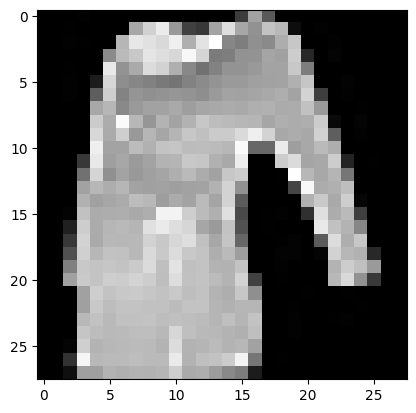

In [18]:
print("b x y c -> ", x.shape)
plt.imshow(x[0,...], cmap="gray");

Text(0, 0.5, 'Density')

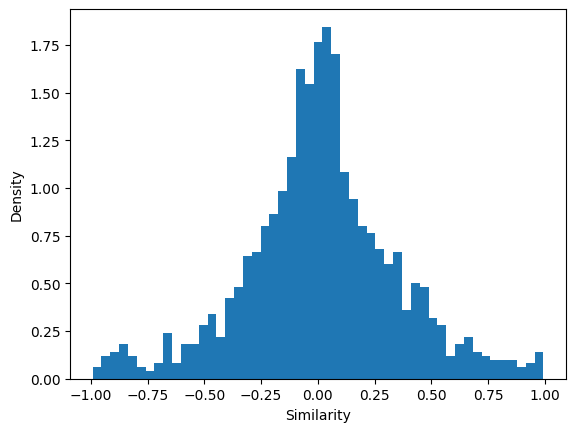

In [19]:
#sample the initial similarities the model produces between an 
# image and the class codebook. 

pred, sp = model.apply(params, key, x)

plt.hist(np.array(pred.ravel()), bins=51, density=True)
plt.xlabel("Similarity")
plt.ylabel("Density")

In [20]:
key, sk1, sk2 = jrnd.split(key, 3)

In [25]:
x = jrnd.uniform(sk1, (100, 4096))
y = jrnd.uniform(sk2, (100, 4096))

(array([417., 400., 407., 418., 412., 381., 418., 413., 411., 419.]),
 array([1.63912773e-04, 1.00139156e-01, 2.00114399e-01, 3.00089628e-01,
        4.00064886e-01, 5.00040114e-01, 6.00015342e-01, 6.99990571e-01,
        7.99965858e-01, 8.99941087e-01, 9.99916315e-01]),
 <BarContainer object of 10 artists>)

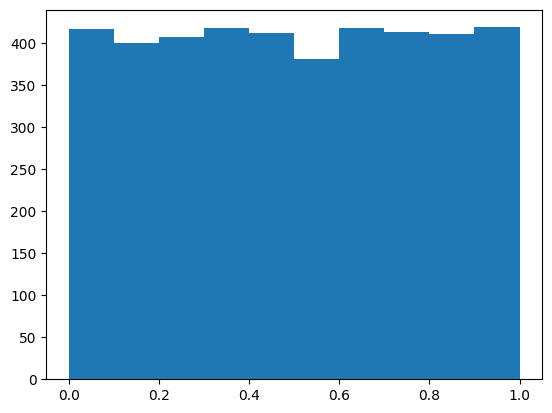

In [33]:
plt.hist(x[0:1,:])

In [30]:
similarity(x[0:1,:],y)

DeviceArray([0.4041183 , 0.40800387, 0.3930021 , 0.40159988, 0.40204313,
             0.4083974 , 0.40159497, 0.39925042, 0.40622875, 0.4006738 ,
             0.40925562, 0.4163357 , 0.4134153 , 0.40258157, 0.40598616,
             0.40426728, 0.40740624, 0.3988736 , 0.4110083 , 0.4014637 ,
             0.41343927, 0.41292107, 0.40139645, 0.40150487, 0.40323436,
             0.40676546, 0.40727538, 0.4021243 , 0.3855608 , 0.3994606 ,
             0.39782593, 0.40865147, 0.37910283, 0.41476685, 0.3998237 ,
             0.4023149 , 0.40820622, 0.415259  , 0.4139107 , 0.3933989 ,
             0.40446636, 0.40082484, 0.40952808, 0.39559552, 0.40865332,
             0.3954803 , 0.4100214 , 0.41215375, 0.4038515 , 0.37545606,
             0.40321517, 0.40694547, 0.4007801 , 0.39599618, 0.40218282,
             0.40502667, 0.41431415, 0.4056437 , 0.39813155, 0.39937484,
             0.4032969 , 0.39172545, 0.4050327 , 0.39333937, 0.39936006,
             0.4043856 , 0.40178296, 0.4050851 , 0.

In [16]:
sp

(DeviceArray(1., dtype=float32), DeviceArray(1., dtype=float32))

Text(0, 0.5, 'Density')

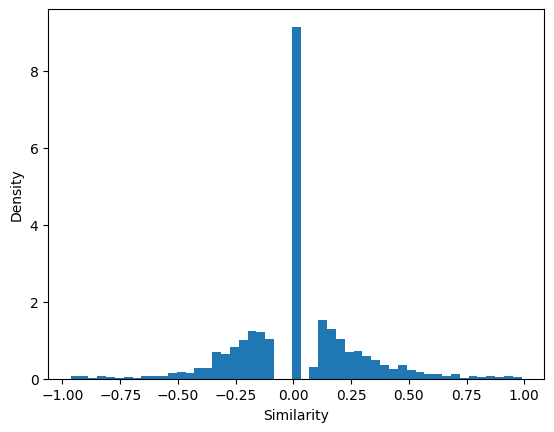

In [17]:
#sample the initial similarities the model produces between an 
# image and the class codebook. 

pred, sp = model.apply(params, key, x, mask_angle = 0.10, spiking=False)

plt.hist(np.array(pred.ravel()), bins=51, density=True)
plt.xlabel("Similarity")
plt.ylabel("Density")


In [18]:
sp

(DeviceArray(0.6531372, dtype=float32), DeviceArray(0.65, dtype=float32))

In [19]:
loss_fn = lambda yh, y: quadrature_loss(yh[0], y, num_classes=10)

In [20]:
# Compute a sample of the loss function over these similarities. 
# Takes the complement of the similarity for the correct class label.
# This value (distance) will be minimized over training.

jnp.mean(loss_fn((pred, sp), y))

DeviceArray(0.34420824, dtype=float32)

# Training

In [21]:
mask_angles = np.linspace(0.0, 0.15, 16)

In [22]:
mask_angles

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15])

In [24]:
train_fn = lambda x: train_model(model, 
                               key, 
                               params = params, 
                               dataset = train, 
                               optimizer = opt, 
                               loss_fn = loss_fn, 
                               batches = 2000,
                               mask_angle = x)

results = list(map(train_fn, mask_angles))

100%|██████████| 2000/2000 [01:03<00:00, 31.45it/s]


In [28]:
all_params = [r[0] for r in results]

In [25]:
all_losses = np.stack([r[1] for r in results])

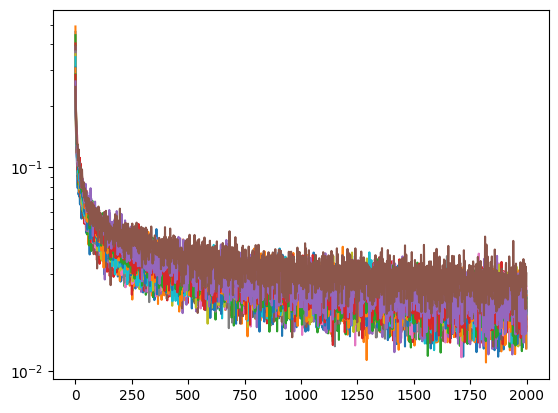

In [26]:
plt.semilogy(all_losses.transpose());

In [31]:
#p.dump(all_params, open("params_maskangle.p", "wb"))

In [23]:
all_params = p.load(open("params_maskangle.p", "rb"))

# Test

In [25]:
#Load the testing dataset
test_ds, x_test, y_test = load_dataset(dataset, split="test", is_training=False, repeat = False, batch_size=n_batch)
test = iter(test_ds)

In [26]:
def evaluate(network, params, key, batch, mask_angle: float = -1.0, spiking: bool = False):
    x = batch['image']
    y = batch['label']

    yhat, sparsity = network.apply(params, key, x, mask_angle = mask_angle, spiking = spiking)
    acc = accuracy_quadrature(yhat, y)
    
    return (acc, sparsity)

In [27]:
eval_nospk = lambda b, p, ma: evaluate(model, p, key, b, mask_angle=ma, spiking=False)
eval_spk = lambda b, p, ma: evaluate(model, p, key, b, mask_angle=ma, spiking=True)


In [28]:
def dispatch_evaluation(eval_fn, all_parameters, mask_angles):
    n = len(mask_angles)
    assert len(all_parameters) == n, "Must have set of parameters for each mask angle"


    def inner_fn(i):
        parameters = all_parameters[i]
        mask_angle = mask_angles[i]

        results = [eval_fn(b, parameters, mask_angle) for b in tqdm(iter(test_ds))]
        acc = np.mean(jnp.concatenate([b[0] for b in results]))
        sparsity = np.mean(jnp.stack([np.array(b[1]) for b in results], axis=0), axis=0)

        return np.array([acc, *sparsity])
    
    all_results = np.stack(list(map(inner_fn, range(n))))

    return all_results

In [29]:
nospk_result = dispatch_evaluation(eval_nospk, all_params, mask_angles)

79it [00:00, 98.97it/s] 
79it [00:00, 144.02it/s]
79it [00:00, 169.38it/s]
79it [00:00, 153.39it/s]
79it [00:00, 163.73it/s]
79it [00:00, 164.16it/s]
79it [00:00, 151.64it/s]
79it [00:00, 162.01it/s]
79it [00:00, 161.61it/s]
79it [00:00, 158.16it/s]
79it [00:00, 172.00it/s]
79it [00:00, 174.85it/s]
79it [00:00, 176.16it/s]
79it [00:00, 162.73it/s]
79it [00:00, 175.01it/s]
79it [00:00, 175.66it/s]


Compute accuracy across mask angles

In [30]:
all_accs = nospk_result[:,0]

In [31]:
all_sparsity = nospk_result[:,1:]

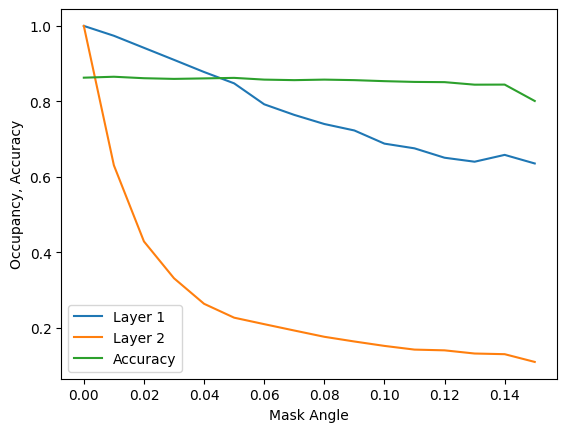

In [33]:
plt.plot(mask_angles, all_sparsity[:,0], label="Layer 1")
plt.plot(mask_angles, all_sparsity[:,1], label="Layer 2")
plt.plot(mask_angles, all_accs, label="Accuracy")
plt.ylabel("Occupancy, Accuracy")
plt.xlabel("Mask Angle")
plt.legend()

Compute spiking accuracy / sparsity

In [41]:
spk_result = dispatch_evaluation(eval_spk, all_params[5:7], mask_angles[5:7])

79it [04:27,  3.38s/it]
79it [04:23,  3.33s/it]


In [42]:
spk_result

array([[0.8207    , 0.9152878 , 1.0087975 ],
       [0.81409997, 0.9099029 , 1.0085285 ]], dtype=float32)

In [45]:
p.dump(spk_result, open("spk_result.p", "wb"))

In [46]:
#last cycle
spk_result

array([[0.8152    , 1.0082031 , 1.008405  ],
       [0.8328    , 1.007434  , 1.0055915 ],
       [0.8269    , 1.0078343 , 1.005259  ],
       [0.8167    , 1.007459  , 1.0047182 ],
       [0.83669996, 1.0071651 , 1.0021639 ],
       [0.8382    , 1.0071409 , 1.0030776 ],
       [0.83309996, 1.0072342 , 1.0027157 ],
       [0.83379996, 1.007139  , 1.0021787 ],
       [0.8154    , 1.0076495 , 1.0022429 ],
       [0.8124    , 1.0078785 , 1.0020669 ],
       [0.79969996, 1.0081054 , 1.0011203 ],
       [0.7513    , 1.0085748 , 1.0004965 ],
       [0.7496    , 1.0088325 , 1.0005281 ],
       [0.74149996, 1.0091583 , 1.0005469 ],
       [0.6055    , 1.0096395 , 1.0015191 ],
       [0.6601    , 1.0090555 , 1.0017414 ]], dtype=float32)

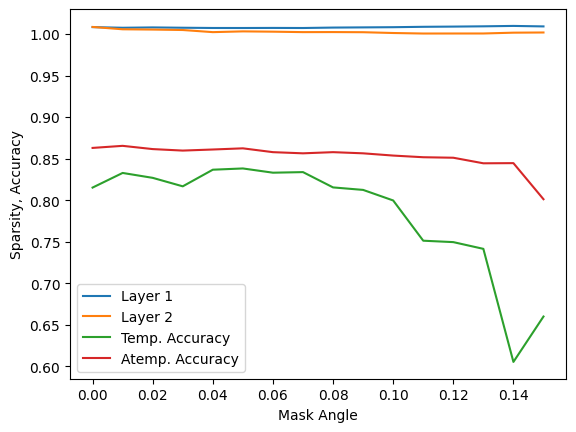

In [49]:
plt.plot(mask_angles, spk_result[:,1], label="Layer 1")
plt.plot(mask_angles, spk_result[:,2], label="Layer 2")
plt.plot(mask_angles, spk_result[:,0], label="Temp. Accuracy")
plt.plot(mask_angles, all_accs, label="Atemp. Accuracy")
plt.ylabel("Sparsity, Accuracy")
plt.xlabel("Mask Angle")
plt.legend()

In [ ]:
#it isn't dropping spikes?